In [3]:
#from PIL import Image
import urllib.request
#from fastDiff import fastDiff
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt


# dataset

We generate a dataset, `y` and a sub-sampled version `y_sub`:

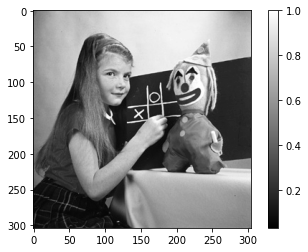

In [2]:

# pull a dataset and make it 1D for now
url='https://upload.wikimedia.org/wikipedia/en/0/04/TCF_centre.jpg'
im = np.array(Image.open(urllib.request.urlopen(url)).convert("L")).astype(float)

# 
y = im/im.max()
plt.imshow(y,cmap='gray')
plt.colorbar()

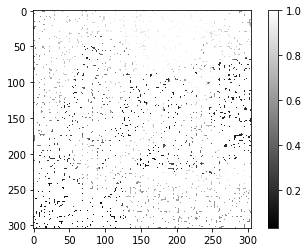

In [16]:
# sub-sample

# how many samples to mask?
nmask = int(y.size * 1/3)

# mask
imin = np.random.choice(y.size,nmask,replace=False)
mask = np.unravel_index(imin,y.shape)

# apply mask
y_sub = y.copy()
y_sub[mask] = np.nan

# plot
plt.imshow(y_sub,cmap='gray')
plt.colorbar()

# Regularisation

We wish to solve problems that involve the term:

$$H = \left( I_n + s D^T D\right)^{-1}$$

where $I_n$ is an identity matrix of size $n$ by $n$, $D$ is a first-order differential operator on a grid with unit spacing and $^T$ stands for the matrix transpose. $s$ is a smoothness parameter. 

* [Garcia D, Robust smoothing of gridded data in one and higher dimensions with missing values. Computational Statistics & Data Analysis, 2010;54:1167-1178.](csda10.pdf)

For example, define a vector of observations $y = \hat{y} + \varepsilon$ where $\varepsilon$ is independent Gaussian noise with  zero mean and vector $\sigma_y^2$. Then we can estimate the noise-free signal $\hat{y}$ from:

$$
\hat{y} = H y
$$

In that context, we can quantify discrepency a $J_y$ as:

$$
J_y = \frac{1}{2 \sigma_y^2} \left( \hat{y} - {y} \right)^T \left( \hat{y} - {y} \right)
$$

Assuming a reflexive boundary condition to the construction of $D$, this can be conveniently expressed in the frequency domain, using a discrete cosine transform (DCT) (Type II). 

Writing $D = U \Lambda U^{−1}$ where $U$ is a forward DCT matrix and $U^{-1}$ the inverse and $\Lambda = diag(\lambda_1,...,\lambda_n)$ with $\lambda_i =−2+2\cos\alpha_i$ with $\alpha_i=(i−1)\pi/n$. Here, $\lambda_i$ are the eigenvalues of $D$.  $U$ is a unitary matrix, so $U^{-1} = U^T$ and:

$$H = \left( I_n + s U \Lambda^2 U^T\right)^{-1}  \equiv U \Gamma U^T $$

The matrix $\Gamma$ is diagonal, with elements all zero other than the leading diagonal which is defined by $\Gamma_{i,i} \equiv \gamma_i = \left(1+s \lambda_i^2\right)^{-1}$. For the evenly-spaced data we have here, the trace of $H$ is $Tr(H) = \sum_{i=1}^{n} \gamma_i$. 

Garcia notes that for large $n$:

$$
\frac{Tr(H)}{n} \approx  \frac{\sqrt{ 1 + s'}}{
\sqrt{2} s'
} 
$$

with $s' = \sqrt{1 + 16 s}$. Also:

$$
J_y = \frac{1}{2 \sigma_y^2} \sum_{i=1}^{n} \left( \gamma_i - 1\right)^2 DCT^2_i(y)
$$

where $DCT_i(y)$ refers to the $i^{th}$ component of the DCT of $y$.

# filter

develop the filters

In [14]:
gamma = 1.
f = fastDiff(y,axis=(0,1),gamma=gamma)
diff = f.diff()

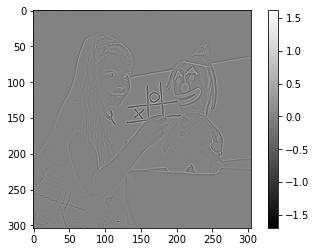

In [15]:
# plot
plt.imshow(diff,cmap='gray')
plt.colorbar()

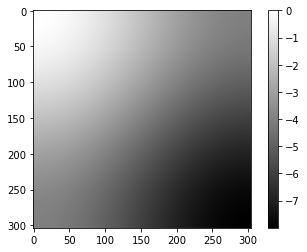

In [11]:
# filter in Frequency domain
plt.imshow(filt,cmap='gray')
plt.colorbar()

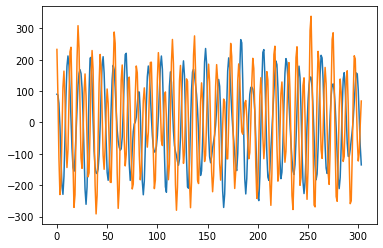

In [13]:
from scipy.fftpack.realtransforms import dct,idct
r = f.dctND(1/(1+filt),f=idct,axis=(0,1))
plt.plot(r[int(r.shape[0]/2)])
plt.plot(r[int(3 *r.shape[0]/2/4)])

array([[-1.21200000e+03,  4.29915184e+02, -9.42792260e-01, ...,
        -4.93715698e-15, -7.80477262e-07,  5.68434189e-14],
       [ 4.29915184e+02,  6.96193571e-19, -2.16434068e-18, ...,
        -2.22960022e-16,  2.09427579e-16, -1.34734821e-16],
       [-9.42792260e-01,  5.34532717e-16, -3.76252857e-16, ...,
        -1.18186558e-15,  6.72403923e-16, -1.01622034e-15],
       ...,
       [-8.33120643e-15, -1.90934961e-16, -2.43450678e-16, ...,
        -2.91109048e-16, -2.70504298e-16, -7.26844540e-16],
       [-7.80477256e-07, -1.59052709e-16,  4.22082145e-17, ...,
        -7.48921525e-17, -5.64584668e-17, -3.12630085e-17],
       [-6.01098207e-14, -1.93173208e-15,  1.04789521e-15, ...,
         2.05272068e-16, -1.98620417e-16,  1.24756890e-16]])

In [11]:
res.keys()

dict_keys(['fun', 'jac', 'nfev', 'njev', 'nhev', 'status', 'success', 'message', 'x', 'nit'])

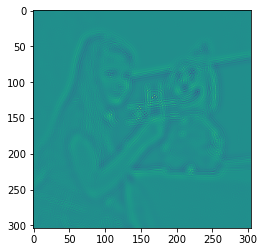

In [12]:
plt.imshow(res['jac'].reshape(x.shape))